In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
from io import StringIO
import sklearn as skn
from scipy import stats
import pandas_datareader.data as pdr
import riskfolio as rp
from scipy.stats import multivariate_normal


In [2]:
def loadStooqData(ticker: str,start, frequency='d'):
    url = f'https://stooq.pl/q/d/l/?s={ticker}&i={frequency}'
    response = requests.get(url)
    data = pd.read_csv(StringIO(response.text))
    data.set_index('Data', inplace=True)
    data = data[start:]
    return data['Zamkniecie']

def loadYahooData(ticker, start, frequency = '1d'):
    ticker  = yf.Ticker(ticker)
    hist = ticker.history(start=start,interval=frequency)
    price = hist['Close']
    return price

def sharp(returns):
    return returns.mean()/returns.std()

def assets_performance(returns: pd.DataFrame):
    return returns.agg(['mean', 'std', 'median', 'skew', 'kurtosis', sharp])

def beta(X, Y):

    X_cov = X.cov()

    XY = np.append(X,np.expand_dims(Y,axis=1),axis=0)
    XY_cov = np.cov(XY)

    #XY_sub = XY_cov.iloc[-1,0:2]

    #inv = np.linalg.inv(X_cov)
    #B = inv @ XY_sub
    return  XY_cov

In [3]:
yahoo_tickers = ['ACWI', 'CORP.L', 'IHYU.L']

stooq_tickers = ['XAUPLN', '^TBSP', 'MWIG40', 'USDPLN', 'EURPLN', 'PLOPLN3M', 'cpiypl.m']

#na przyszłość EAFA,EEM,ACWI



In [4]:
base_prices = pd.DataFrame({})
start = '2008-01-01'

for ticker in stooq_tickers:
    base_prices[ticker] = loadStooqData(ticker,start)

for ticker in yahoo_tickers:
    base_prices[ticker] = loadYahooData(ticker,start)

base_prices.index = pd.DatetimeIndex(base_prices.index)


In [5]:
#get monthly data
monthly_base_prices = base_prices.resample('m').last()

In [6]:
monthly_base_returns = np.log(monthly_base_prices/monthly_base_prices.shift(1))
assets_performance(monthly_base_returns)

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,XAUPLN,^TBSP,MWIG40,USDPLN,EURPLN,PLOPLN3M,cpiypl.m,ACWI,CORP.L,IHYU.L
mean,0.007023,0.003299,0.002131,0.003110,0.001364,0.000149,NaN,0.005148,-0.001419,-0.000514
std,0.053746,0.012761,0.060556,0.040246,0.021872,0.149061,NaN,0.050441,0.019824,0.023175
median,0.004787,0.003807,0.006117,0.001067,-0.000887,0.000000,0.0,0.011890,0.001680,0.001762
skew,0.582459,0.196288,-0.958106,0.769922,0.654253,2.911517,NaN,-0.754408,-0.676974,-0.217839
kurtosis,1.876830,5.259098,5.521602,1.919377,2.446433,38.402053,NaN,1.540994,2.443221,2.453854
sharp,0.130675,0.258474,0.035192,0.077271,0.062350,0.000996,NaN,0.102067,-0.071567,-0.022172


In [7]:
monthly_base_returns.corr()

,XAUPLN,^TBSP,MWIG40,USDPLN,EURPLN,PLOPLN3M,cpiypl.m,ACWI,CORP.L,IHYU.L
XAUPLN,1.000000,0.087131,-0.266077,0.491061,0.529705,-0.024872,0.110361,-0.386669,0.017369,0.005720
^TBSP,0.087131,1.000000,0.155060,-0.197234,-0.096925,-0.384985,0.008430,0.229505,0.533880,0.260986
MWIG40,-0.266077,0.155060,1.000000,-0.566334,-0.538498,-0.035546,0.020253,0.773950,0.545958,0.547157
USDPLN,0.491061,-0.197234,-0.566334,1.000000,0.754326,0.012184,-0.071888,-0.713854,-0.602964,-0.406373
EURPLN,0.529705,-0.096925,-0.538498,0.754326,1.000000,-0.037088,-0.078589,-0.565706,-0.436088,-0.393250
PLOPLN3M,-0.024872,-0.384985,-0.035546,0.012184,-0.037088,1.000000,0.109534,-0.020341,-0.107254,-0.088580
cpiypl.m,0.110361,0.008430,0.020253,-0.071888,-0.078589,0.109534,1.000000,0.066850,0.072245,0.091172
ACWI,-0.386669,0.229505,0.773950,-0.713854,-0.565706,-0.020341,0.066850,1.000000,0.686976,0.708720
CORP.L,0.017369,0.533880,0.545958,-0.602964,-0.436088,-0.107254,0.072245,0.686976,1.000000,0.593901
IHYU.L,0.005720,0.260986,0.547157,-0.406373,-0.393250,-0.088580,0.091172,0.708720,0.593901,1.000000


In [43]:
#calculate pln returns
pln_prices = monthly_base_prices
pln_prices['ACWI'] = monthly_base_prices['ACWI'] * monthly_base_prices['USDPLN']
pln_prices['CORP.L'] = monthly_base_prices['CORP.L'] * monthly_base_prices['USDPLN']
pln_returns = np.log(pln_prices/pln_prices.shift(1))
pln_returns['PLOPLN3M'] = pln_prices['PLOPLN3M'] / 100 / 12
pln_returns['cpiypl.m'] = pln_prices['cpiypl.m'] / 100
pln_returns['edo'] = (pln_returns['cpiypl.m'].rolling(12).mean() + 0.0125)/ 12
assets_performance(pln_returns)

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,XAUPLN,^TBSP,MWIG40,USDPLN,EURPLN,PLOPLN3M,cpiypl.m,ACWI,CORP.L,IHYU.L,edo
mean,0.007023,0.003299,0.002131,0.003110,0.001364,0.002676,0.035742,0.012380,0.003306,-0.000514,0.003918
std,0.053746,0.012761,0.060556,0.040246,0.021872,0.001679,0.042331,0.056666,0.049954,0.023175,0.003341
median,0.004787,0.003807,0.006117,0.001067,-0.000887,0.002250,0.028000,0.010363,0.003696,0.001762,0.003687
skew,0.582459,0.196288,-0.958106,0.769922,0.654253,0.461856,1.896343,0.516523,-0.055697,-0.217839,1.803454
kurtosis,1.876830,5.259098,5.521602,1.919377,2.446433,-0.846268,3.521443,0.748995,-0.688645,2.453854,3.245997
sharp,0.130675,0.258474,0.035192,0.077271,0.062350,1.593511,0.844335,0.218480,0.066181,-0.022172,1.172819


In [44]:
pln_returns.corr()

,XAUPLN,^TBSP,MWIG40,USDPLN,EURPLN,PLOPLN3M,cpiypl.m,ACWI,CORP.L,IHYU.L,edo
XAUPLN,1.000000,0.087131,-0.266077,0.491061,0.529705,0.031067,0.004222,0.347459,0.461550,0.005720,-0.022162
^TBSP,0.087131,1.000000,0.155060,-0.197234,-0.096925,0.136493,-0.026698,-0.087554,-0.055023,0.260986,0.071972
MWIG40,-0.266077,0.155060,1.000000,-0.566334,-0.538498,-0.162072,-0.047628,-0.121484,-0.334451,0.547157,0.031006
USDPLN,0.491061,-0.197234,-0.566334,1.000000,0.754326,0.049255,-0.033413,0.781925,0.948564,-0.406373,-0.057371
EURPLN,0.529705,-0.096925,-0.538498,0.754326,1.000000,0.028775,-0.038839,0.565375,0.704864,-0.393250,-0.046809
PLOPLN3M,0.031067,0.136493,-0.162072,0.049255,0.028775,1.000000,0.648213,-0.038118,-0.062846,-0.011353,0.733841
cpiypl.m,0.004222,-0.026698,-0.047628,-0.033413,-0.038839,0.648213,1.000000,-0.093799,-0.112481,-0.057799,0.927024
ACWI,0.347459,-0.087554,-0.121484,0.781925,0.565375,-0.038118,-0.093799,1.000000,0.811235,0.059408,-0.084902
CORP.L,0.461550,-0.055023,-0.334451,0.948564,0.704864,-0.062846,-0.112481,0.811235,1.000000,-0.179356,-0.146286
IHYU.L,0.005720,0.260986,0.547157,-0.406373,-0.393250,-0.011353,-0.057799,0.059408,-0.179356,1.000000,-0.000098


In [45]:
pln_returns.mean() * 12

XAUPLN      0.084279
^TBSP       0.039582
MWIG40      0.025573
USDPLN      0.037318
EURPLN      0.016364
PLOPLN3M    0.032113
cpiypl.m    0.428903
ACWI        0.148564
CORP.L      0.039672
IHYU.L     -0.006166
edo         0.047019
dtype: float64

In [86]:
pln_returns[['ACWI','edo']].cov()

,ACWI,edo
ACWI,0.003211,-0.000016
edo,-0.000016,0.000011


In [46]:
describe = pln_returns.describe()

In [47]:
expected_returns = pd.Series({
'ACWI': 0.07/12,
'^TBSP': 0.049/12,
'XAUPLN': 0.05/12,
'MWIG40': 0.065/12,
'IHYU.L': 0.038/12,
'PLOPLN3M': 0.03/12,
'edo': 0.04/12
})


* load data
* describe data in local currency
* transform data do pln
* describe data in pln

In [48]:
assets = ['ACWI', '^TBSP', 'XAUPLN', 'MWIG40', 'PLOPLN3M', 'edo']
#
returns = pln_returns[assets]
cov_matrix = pln_returns[assets].cov()
mu = expected_returns[assets]

portfolio = rp.Portfolio(returns)

portfolio.mu = mu
portfolio.cov = cov_matrix

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = portfolio.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo
weights,0.00364,0.005401,0.001091,0.00649,0.983378,1.213610e-09


In [49]:
w = portfolio.optimization(model=model, rm=rm, obj='MaxRet', rf=rf, l=l, hist=hist)

display(np.round(w.T,2))

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo
weights,1.0,0.0,0.0,0.0,0.0,0.0


In [50]:
def frontier_performance(frontier,mu,cov,rf = 0.0):
    result = frontier.copy()
    result['Returns'] = np.round(frontier.to_numpy() @ mu *12,4)
    result['Std. deviations'] = frontier.apply(lambda x: np.round(np.sqrt(x.to_numpy().T @ cov @ x.to_numpy())* np.sqrt(12),4),axis=1)
    result['SR'] = np.round((result['Returns']-rf) / result['Std. deviations'],2)
    return result


In [51]:
def shrinkedCovariance(returns: pd.DataFrame, w: int):
    std = np.diag(returns.std())
    corr = returns.corr('pearson')
    shrinked_corr = (1-w)*corr + np.ones_like(corr)*w
    result = std @ shrinked_corr @ std
    return result

shrin_param = 0.75

In [52]:
points = 10
frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_10 = np.round(frontier.T,2)

In [53]:
frontier_performance(frontier_10, expected_returns[assets],cov_matrix,0.0298)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.00,0.0,0.01,0.99,0.00,0.0304,0.0058,0.10
1,0.09,0.42,0.0,0.05,0.00,0.44,0.0477,0.0274,0.65
2,0.16,0.75,0.0,0.09,0.00,0.00,0.0538,0.0480,0.50
3,0.29,0.52,0.0,0.19,0.00,0.00,0.0581,0.0697,0.41
4,0.39,0.35,0.0,0.27,0.00,0.00,0.0620,0.0912,0.35
5,0.48,0.18,0.0,0.34,0.00,0.00,0.0645,0.1115,0.31
6,0.57,0.02,0.0,0.41,0.00,0.00,0.0675,0.1326,0.28
7,0.78,0.00,0.0,0.22,0.00,0.00,0.0689,0.1544,0.25
8,0.90,0.00,0.0,0.10,0.00,0.00,0.0695,0.1753,0.23
9,1.00,0.00,0.0,0.00,0.00,0.00,0.0700,0.1963,0.20


In [54]:
mu = expected_returns[assets]
shrinked_cov = shrinkedCovariance(pln_returns[assets],shrin_param)

portfolio.mu = mu
portfolio.cov = shrinked_cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_10_sh = np.round(frontier.T,2)

In [55]:
frontier_performance(frontier_10_sh,mu,shrinked_cov,0.0298)


,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.00,0.0,0.00,1.0,0.00,0.0300,0.0058,0.03
1,0.00,0.51,0.0,0.00,0.0,0.49,0.0446,0.0271,0.55
2,0.04,0.96,0.0,0.00,0.0,0.00,0.0498,0.0485,0.41
3,0.20,0.80,0.0,0.00,0.0,0.00,0.0532,0.0694,0.34
4,0.34,0.66,0.0,0.00,0.0,0.00,0.0561,0.0902,0.29
5,0.48,0.52,0.0,0.00,0.0,0.00,0.0591,0.1121,0.26
6,0.61,0.39,0.0,0.00,0.0,0.00,0.0618,0.1328,0.24
7,0.73,0.25,0.0,0.02,0.0,0.00,0.0647,0.1547,0.23
8,0.84,0.12,0.0,0.04,0.0,0.00,0.0673,0.1750,0.21
9,1.00,0.00,0.0,0.00,0.0,0.00,0.0700,0.1963,0.20


In [56]:
mu = expected_returns[assets]
cov = pln_returns[0:60][assets].cov()

portfolio.mu = mu
portfolio.cov = cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_1_5 = np.round(frontier.T,2)

In [57]:
frontier_performance(frontier_1_5,mu,cov)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.00,0.0,0.00,0.25,0.75,0.0375,0.0016,23.44
1,0.07,0.72,0.0,0.01,0.00,0.20,0.0488,0.0284,1.72
2,0.20,0.69,0.0,0.11,0.00,0.00,0.0550,0.0556,0.99
3,0.31,0.48,0.0,0.21,0.00,0.00,0.0589,0.0825,0.71
4,0.41,0.29,0.0,0.30,0.00,0.00,0.0624,0.1087,0.57
5,0.51,0.10,0.0,0.39,0.00,0.00,0.0660,0.1355,0.49
6,0.69,0.00,0.0,0.31,0.00,0.00,0.0684,0.1627,0.42
7,0.82,0.00,0.0,0.18,0.00,0.00,0.0691,0.1904,0.36
8,0.91,0.00,0.0,0.09,0.00,0.00,0.0696,0.2154,0.32
9,1.00,0.00,0.0,0.00,0.00,0.00,0.0700,0.2435,0.29


In [58]:
mu = expected_returns[assets]
shrinked_cov = shrinkedCovariance(pln_returns[0:60][assets],shrin_param)

portfolio.mu = mu
portfolio.cov = shrinked_cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_1_5_sh = np.round(frontier.T,2)

In [59]:
frontier_performance(frontier_1_5_sh,mu,shrinked_cov)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.00,0.0,0.00,0.0,1.00,0.0400,0.0016,25.00
1,0.00,0.82,0.0,0.00,0.0,0.18,0.0474,0.0286,1.66
2,0.12,0.88,0.0,0.00,0.0,0.00,0.0515,0.0551,0.93
3,0.25,0.75,0.0,0.00,0.0,0.00,0.0542,0.0813,0.67
4,0.38,0.62,0.0,0.00,0.0,0.00,0.0570,0.1088,0.52
5,0.51,0.49,0.0,0.00,0.0,0.00,0.0597,0.1367,0.44
6,0.62,0.36,0.0,0.02,0.0,0.00,0.0623,0.1638,0.38
7,0.72,0.24,0.0,0.04,0.0,0.00,0.0648,0.1888,0.34
8,0.83,0.11,0.0,0.06,0.0,0.00,0.0674,0.2160,0.31
9,1.00,0.00,0.0,0.00,0.0,0.00,0.0700,0.2435,0.29


In [60]:
mu = expected_returns[assets]
cov = pln_returns[60:120][assets].cov()

portfolio.mu = mu
portfolio.cov = cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_5_10 = np.round(frontier.T,2)

In [61]:
frontier_performance(frontier_5_10,mu,cov)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.00,0.0,0.00,1.0,0.00,0.0300,0.0017,17.65
1,0.06,0.49,0.0,0.08,0.0,0.37,0.0482,0.0203,2.37
2,0.15,0.65,0.0,0.20,0.0,0.00,0.0554,0.0398,1.39
3,0.24,0.43,0.0,0.33,0.0,0.00,0.0593,0.0588,1.01
4,0.32,0.24,0.0,0.44,0.0,0.00,0.0628,0.0778,0.81
5,0.39,0.06,0.0,0.55,0.0,0.00,0.0660,0.0964,0.68
6,0.60,0.00,0.0,0.40,0.0,0.00,0.0680,0.1151,0.59
7,0.76,0.00,0.0,0.24,0.0,0.00,0.0688,0.1344,0.51
8,0.89,0.00,0.0,0.11,0.0,0.00,0.0695,0.1538,0.45
9,1.00,0.00,0.0,0.00,0.0,0.00,0.0700,0.1721,0.41


In [62]:
shrinked_cov = shrinkedCovariance(pln_returns[60:120][assets],shrin_param)

portfolio.mu = mu
portfolio.cov = shrinked_cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_5_10_sh = np.round(frontier.T,2)

In [63]:
frontier_performance(frontier_5_10_sh,mu,shrinked_cov)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.00,0.0,0.00,1.0,0.00,0.0300,0.0017,17.65
1,0.00,0.61,0.0,0.00,0.0,0.39,0.0455,0.0207,2.20
2,0.00,0.90,0.0,0.10,0.0,0.00,0.0506,0.0394,1.28
3,0.06,0.70,0.0,0.24,0.0,0.00,0.0541,0.0579,0.93
4,0.12,0.51,0.0,0.37,0.0,0.00,0.0574,0.0771,0.74
5,0.18,0.32,0.0,0.50,0.0,0.00,0.0608,0.0969,0.63
6,0.23,0.14,0.0,0.63,0.0,0.00,0.0639,0.1156,0.55
7,0.38,0.00,0.0,0.62,0.0,0.00,0.0669,0.1343,0.50
8,0.74,0.00,0.0,0.26,0.0,0.00,0.0687,0.1534,0.45
9,1.00,0.00,0.0,0.00,0.0,0.00,0.0700,0.1721,0.41


In [64]:
start = '01.12.2006'
tbsp = loadStooqData('^TBSP',start,'m')
wibor3 = loadStooqData('PLOPLN3M',start,'m')
cpi = loadStooqData('cpimpl.m',start,'m')

In [65]:
tbsp = np.log(tbsp/tbsp.shift(1))
wibor3 = wibor3/100/12
cpi = cpi/100

In [66]:
tbsp.loc['2007-01-01':].mean()*12
#'2019-12-31'

0.03898302124937854

In [67]:
wibor3.loc['2007-01-01':].mean() * 12

0.03306169154228855

In [68]:
cpi.loc['2007-01-01':].mean() *12

0.036000000000000025

In [69]:
print(tbsp.loc['2007-01-01':'2019-12-31'].mean()*12)
print(wibor3.loc['2007-01-01':'2019-12-31'].mean() * 12)
print(cpi.loc['2007-01-01':'2019-19-31'].mean() *12)

0.049864919419809195
0.03302307692307694
0.02115384615384617


In [70]:
tbsp_cum = (1+tbsp.loc['2007-01-01':'2023-06-31']).cumprod()[-1]
cpi_cum = (1.00125+cpi.loc['2007-01-01':'2023-06-31']).cumprod()[-1]
wibor_cum = (1+wibor3.loc['2007-01-01':'2023-06-31']/12).cumprod()[-1]

In [71]:
print(tbsp_cum)
print(cpi_cum)
print(wibor_cum)

1.8398585720934704
2.3014767048682354
1.045825968849171


In [72]:
assets = ['ACWI', '^TBSP']
means = expected_returns[assets]
cov = pln_returns[assets].cov()
number_of_scenarios = 1001
T = 120
sim_returns = []

for s in range (number_of_scenarios):
    sim_returns.append(multivariate_normal.rvs(means,cov, T))

sim_returns = np.array(sim_returns)

In [73]:
pln_returns[assets].cov()

,ACWI,^TBSP
ACWI,0.003211,-0.000063
^TBSP,-0.000063,0.000163


In [74]:
means = np.sort(sim_returns[:,:,1].mean(1)) 

In [75]:
prices = (1+ sim_returns).cumprod(1)
prices = prices *100
reshaped = prices.reshape(1001,-1)
np.savetxt('sim_prices.csv',reshaped, delimiter=',')

In [76]:
reshaped.reshape(1001,120,2).shape

(1001, 120, 2)

In [77]:
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'
points = 10
weights = np.zeros((number_of_scenarios,len(assets),points))

for p in range(number_of_scenarios):
    portfolio = rp.Portfolio(pd.DataFrame(sim_returns[p], columns=assets))
    portfolio.assets_stats(method_mu='hist', method_cov='hist')
    w = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
    weights[p,:] = w.to_numpy()


In [78]:
w_means = np.round(weights.mean(0),2)
w_means_df = pd.DataFrame(w_means.T, columns=assets)

In [79]:
w_means_df

,ACWI,^TBSP
0,0.06,0.94
1,0.19,0.81
2,0.25,0.75
3,0.31,0.69
4,0.37,0.63
5,0.43,0.57
6,0.48,0.52
7,0.54,0.46
8,0.59,0.41
9,0.64,0.36


In [80]:
sim_returns.mean(1) * 12

array([[-0.02979729,  0.0415104 ],
       [ 0.1368307 ,  0.05044111],
       [ 0.06332514,  0.01190256],
       ...,
       [ 0.09836074,  0.05950086],
       [ 0.02674964,  0.05342374],
       [ 0.03326636,  0.03741848]])

In [81]:
def turbulance(returns, mean, cov):
    diff = returns - mean
    result = diff.T @ np.linalg.inv(cov) @ diff 
    return result/len(mean)

assets = ['ACWI', '^TBSP', 'XAUPLN', 'MWIG40','PLOPLN3M', 'edo']
returns = pln_returns['2008-01-01':'2022-12-31'][assets]
mean = returns.mean()
cov_matrix = returns.cov()

returns['Turbulance'] = returns.apply(turbulance, axis=1, args=(mean, cov_matrix))
returns['Reccesion'] = returns['Turbulance'] > 1.5

<AxesSubplot:xlabel='Data', ylabel='Turbulance'>

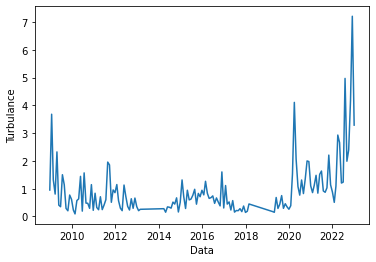

In [82]:
sns.lineplot(data=returns['Turbulance'])

In [83]:
turbulance_returns = returns[returns['Reccesion'] == True]
assets_performance(turbulance_returns)

C:\Users\matsz\AppData\Local\Temp\ipykernel_35368\1005095042.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  return returns.mean()/returns.std()


,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Turbulance,Reccesion
mean,0.021693,0.000159,0.008267,0.000926,0.003170,0.005987,2.660649,1.0
std,0.085661,0.025896,0.077629,0.110060,0.002279,0.003492,1.390114,0.0
median,0.007566,0.004125,0.016560,0.011015,0.003583,0.004243,2.064026,1.0
skew,0.639332,0.521596,0.723278,-0.074349,-0.073811,0.863208,1.935519,0.0
kurtosis,-0.312621,1.127189,2.212699,-0.719821,-1.572784,-0.481916,4.204715,0.0
sharp,0.253245,0.006125,0.106488,0.008409,1.390985,1.714452,1.913978,inf


In [84]:
turbulance_returns.corr()

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Turbulance,Reccesion
ACWI,1.000000,-0.056149,0.423977,-0.132307,-0.101817,-0.273384,0.019895,NaN
^TBSP,-0.056149,1.000000,0.050020,0.071328,0.040730,0.055138,0.464746,NaN
XAUPLN,0.423977,0.050020,1.000000,-0.512939,0.053434,-0.022003,0.199909,NaN
MWIG40,-0.132307,0.071328,-0.512939,1.000000,-0.073393,0.028897,-0.022139,NaN
PLOPLN3M,-0.101817,0.040730,0.053434,-0.073393,1.000000,0.810996,0.522518,NaN
edo,-0.273384,0.055138,-0.022003,0.028897,0.810996,1.000000,0.636086,NaN
Turbulance,0.019895,0.464746,0.199909,-0.022139,0.522518,0.636086,1.000000,NaN
Reccesion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
turbulente_mu = turbulance_returns[assets].mean()
turbulente_cov = turbulance_returns[assets].cov()

porfolio = rp.Portfolio(turbulance_returns[assets].dropna())
portfolio.mu = turbulente_mu
portfolio.cov = turbulente_cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_turbulent = np.round(frontier.T,2)
frontier_performance(frontier_turbulent, mu, cov, 0.004*12)

ValueError: operands could not be broadcast together with shapes (120,2) (120,6) 

In [ ]:
non_turbulance_returns = returns[returns['Reccesion'] == False]
assets_performance(non_turbulance_returns)

C:\Users\matsz\AppData\Local\Temp\ipykernel_17260\1005095042.py:16: RuntimeWarning: invalid value encountered in double_scalars
  return returns.mean()/returns.std()


,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Turbulance,Reccesion
mean,0.008656,0.003200,0.005879,0.000781,0.002443,0.003062,0.628910,0.0
std,0.032753,0.009416,0.051470,0.051227,0.001433,0.001705,0.369749,0.0
median,0.009164,0.003491,0.000401,0.005461,0.002137,0.003458,0.548587,0.0
skew,-0.397294,-0.057245,0.357363,-1.778160,0.535762,0.192436,0.592900,0.0
kurtosis,0.926287,1.722408,1.145294,10.290743,-0.538761,0.170469,-0.717854,0.0
sharp,0.264295,0.339845,0.114225,0.015244,1.705179,1.795560,1.700911,NaN


In [ ]:
non_turbulance_returns.corr()

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Turbulance,Reccesion
ACWI,1.000000,0.016044,0.036198,0.365537,-0.172018,-0.062424,0.014761,NaN
^TBSP,0.016044,1.000000,0.092410,0.193968,0.160374,-0.042221,-0.219029,NaN
XAUPLN,0.036198,0.092410,1.000000,-0.169169,0.025328,0.036885,0.170878,NaN
MWIG40,0.365537,0.193968,-0.169169,1.000000,-0.293398,-0.108534,-0.049825,NaN
PLOPLN3M,-0.172018,0.160374,0.025328,-0.293398,1.000000,0.581642,-0.069924,NaN
edo,-0.062424,-0.042221,0.036885,-0.108534,0.581642,1.000000,0.154609,NaN
Turbulance,0.014761,-0.219029,0.170878,-0.049825,-0.069924,0.154609,1.000000,NaN
Reccesion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
non_turbulance_mu = non_turbulance_returns[assets].mean()
non_turbulance_cov = non_turbulance_returns[assets].cov()

porfolio = rp.Portfolio(non_turbulance_returns[assets].dropna())
portfolio.mu = non_turbulance_mu
portfolio.cov = non_turbulance_cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_non_turbulent = np.round(frontier.T,2)
frontier_performance(frontier_non_turbulent, mu, cov, 0.002498*12)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.00,0.00,0.01,0.72,0.27,0.0332,0.0069,0.47
1,0.13,0.05,0.02,0.00,0.00,0.79,0.0464,0.0186,0.88
2,0.24,0.06,0.04,0.00,0.00,0.66,0.0523,0.0313,0.71
3,0.34,0.06,0.06,0.00,0.00,0.53,0.0569,0.0437,0.62
4,0.44,0.07,0.08,0.00,0.00,0.41,0.0624,0.0565,0.57
5,0.55,0.08,0.10,0.00,0.00,0.28,0.0684,0.0706,0.54
6,0.65,0.09,0.12,0.00,0.00,0.15,0.0735,0.0835,0.52
7,0.75,0.09,0.14,0.00,0.00,0.02,0.0781,0.0965,0.50
8,0.86,0.00,0.14,0.00,0.00,0.00,0.0822,0.1091,0.48
9,1.00,0.00,0.00,0.00,0.00,0.00,0.0850,0.1232,0.45


In [ ]:
mu = 0.1*turbulente_mu + 0.9 * non_turbulance_mu
cov = 0.1*turbulente_cov + 0.9 * non_turbulance_cov

porfolio = rp.Portfolio(returns[assets].dropna())
portfolio.mu = mu
portfolio.cov = cov

frontier = portfolio.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

frontier_combined = np.round(frontier.T,2)
frontier_performance(frontier_combined, mu, cov, 0.002498*12)

,ACWI,^TBSP,XAUPLN,MWIG40,PLOPLN3M,edo,Returns,Std. deviations,SR
0,0.00,0.0,0.00,0.0,0.8,0.19,0.0320,0.0052,0.39
1,0.13,0.0,0.04,0.0,0.0,0.83,0.0507,0.0182,1.14
2,0.23,0.0,0.07,0.0,0.0,0.70,0.0581,0.0314,0.90
3,0.33,0.0,0.10,0.0,0.0,0.57,0.0655,0.0449,0.79
4,0.43,0.0,0.13,0.0,0.0,0.44,0.0729,0.0584,0.74
5,0.52,0.0,0.16,0.0,0.0,0.32,0.0797,0.0709,0.70
6,0.62,0.0,0.19,0.0,0.0,0.19,0.0871,0.0846,0.68
7,0.72,0.0,0.22,0.0,0.0,0.07,0.0949,0.0983,0.66
8,0.87,0.0,0.13,0.0,0.0,0.00,0.0999,0.1107,0.63
9,1.00,0.0,0.00,0.0,0.0,0.00,0.1023,0.1242,0.58
